In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Clean Data

In [2]:
folder = '../data/clean_data/'

df_categories = pd.read_csv(f'{folder}df_categories.csv')
df_comments = pd.read_parquet(f'{folder}df_comments_video.parquet')
df_transcript = pd.read_csv(f'{folder}df_transcript_original.csv')
df_videos = pd.read_csv(f'{folder}df_video_data.csv')
df_channel = pd.read_csv(f'{folder}df_channel_data.csv')
df_content = pd.read_csv(f'{folder}df_content.csv')

In [3]:
df_videos['tags'].head()

0    ['Education', '2023 Latest AI tools', 'AI for ...
1    ['Facebook A.I. Robots shut down', 'facebook a...
2    ['MATLAB', 'Simulink', 'MathWorks', '624592559...
3                                                   []
4    ['Documentary', 'Documentaries', 'documentarie...
Name: tags, dtype: object

# TF-IDF model for `df_transcripts` and `df_comments`

# Modelo 1

Variables: `clean_text`, `video_id`

In [4]:
model1 = df_content.copy()
model1.head()

,video_id,transcription,language,clean_text,comment_list
0,qtlUwwtvuEg,[Music] thank you hello everyone I hope you ar...,english,music thank hello everyone hope great era ai w...,great videohelpful\n thank well explained vide...
1,QaoDXYYtgK0,number three [Music] Facebook has enacted an e...,english,number three music facebook enacted emergency ...,quotthey invented code languagequot man thats ...
2,PqDwddEHswU,in this series we're going to introduce deep l...,english,series going introduce deep learning least per...,brian douglas hero\n learned far sitting couch...
3,B-Y7rnOa43w,this is how to earn money with AI and it's par...,english,earn money ai part two let go want create kind...,oh im going try\n brilliant
4,vyit-1zKsZ4,when current Medical Science has run out of op...,english,current medical science run option doctor dont...,locked syndrome lateral amyloid multiple scler...



El parámetro ngram_range en TfidfVectorizer se refiere a los tamaños de n-gramas que el vectorizador debe considerar al analizar el texto. Un n-grama es una secuencia de "n" palabras consecutivas en un texto.

Desglose de ngram_range=(1, 2):
Unigrama (1-gram): Es una secuencia de 1 palabra. Si ngram_range=(1, 1), el vectorizador solo consideraría palabras individuales.

Ejemplo: Para la frase "hola mundo", los unigramas serían: ["hola", "mundo"].
Bigramas (2-gram): Es una secuencia de 2 palabras consecutivas. Si ngram_range=(2, 2), el vectorizador solo consideraría pares de palabras consecutivas.

Ejemplo: Para la frase "hola mundo", los bigramas serían: ["hola mundo"].
ngram_range=(1, 2): Con este rango, el vectorizador considerará tanto unigramas como bigramas. Es decir, se generarán características tanto para palabras individuales como para pares de palabras consecutivas.

Ejemplo: Para la frase "hola mundo", los n-gramas serían: ["hola", "mundo", "hola mundo"]

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

# Aplicar TF-IDF a comentarios
tfidf_transcripts = tfidf_vectorizer.fit_transform(model1['clean_text'])

# Convertir a DataFrame para visualizar las características
tfidf_transcripts_df = pd.DataFrame(tfidf_transcripts.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print(f'tfidf_transcript: {tfidf_transcripts_df.shape}')


tfidf_transcript: (1787, 5000)


In [6]:
from matplotlib.colors import LinearSegmentedColormap

"""
# Configurar el tamaño del gráfico
plt.figure(figsize=(16, 12))


# Crear el heatmap con un zoom random
cmap = LinearSegmentedColormap.from_list("white_to_blue", ["white", "blue"])

zoom_size = 100
x = np.random.randint(0, len(cosine_df))
sns.heatmap(cosine_df.iloc[x:x+zoom_size, x:x+zoom_size], cmap=cmap, annot=False)

# Agregar título y etiquetas
plt.title('Heatmap of Similarity Cosine Matrix')
plt.xlabel('Video ID')
plt.ylabel('Video ID')

plt.savefig('../assets/similarity_cousine_heatmap.jpg', dpi=150, bbox_inches='tight')

# Mostrar el heatmap
plt.show()
"""

'\n# Configurar el tamaño del gráfico\nplt.figure(figsize=(16, 12))\n\n\n# Crear el heatmap con un zoom random\ncmap = LinearSegmentedColormap.from_list("white_to_blue", ["white", "blue"])\n\nzoom_size = 100\nx = np.random.randint(0, len(cosine_df))\nsns.heatmap(cosine_df.iloc[x:x+zoom_size, x:x+zoom_size], cmap=cmap, annot=False)\n\n# Agregar título y etiquetas\nplt.title(\'Heatmap of Similarity Cosine Matrix\')\nplt.xlabel(\'Video ID\')\nplt.ylabel(\'Video ID\')\n\nplt.savefig(\'../assets/similarity_cousine_heatmap.jpg\', dpi=150, bbox_inches=\'tight\')\n\n# Mostrar el heatmap\nplt.show()\n'

# Get recommendations based on transcriptions `VALID`

La similitud coseno (cosine similarity) es una medida de similitud entre dos vectores en un espacio vectorial que calcula el coseno del ángulo entre ellos. Es ampliamente utilizada en procesamiento de lenguaje natural (NLP), recuperación de información, y otras áreas relacionadas con la comparación de texto o documentos, ya que es eficiente y proporciona una buena estimación de la similitud entre documentos o textos representados como vectores.

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

def create_tfidf_matrix(df):
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])
    
    return tfidf_vectorizer, tfidf_matrix

def calculate_cosine_similarity(tfidf_matrix, video_ids):
    cosine_sim_matrix = cosine_similarity(tfidf_matrix)
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=video_ids, columns=video_ids)
    return cosine_sim_df

def save_model(tfidf_vectorizer, model_name='tfidf_vectorizer_model.pkl'):
    joblib.dump(tfidf_vectorizer, model_name)
    

In [8]:
df = model1.copy()

tfidf_vectorizer, tfidf_matrix = create_tfidf_matrix(df)
cosine_sim_matrix = calculate_cosine_similarity(tfidf_matrix, df['video_id'])
save_model(tfidf_vectorizer)
cosine_sim_matrix

video_id,qtlUwwtvuEg,QaoDXYYtgK0,PqDwddEHswU,B-Y7rnOa43w,vyit-1zKsZ4,MWNqE4z2C34,SWeQO2SEOmQ,pRC4M5Na3jM,ax-3m4GSa1c,_8fDMmnDyYQ,...,I7Uqlv1WX18,qvbZmxUbGaE,Y2FOUg_jo7k,9gmeVAmsTW4,uuh7spVdf0c,Bm6CAjVtrIw,atiYXm7JZv0,plKAsDIiEJo,ZQazWxegNm8,CkG15bX4z90
video_id,,,,,,,,,,,,,,,,,,,,,
qtlUwwtvuEg,1.000000,0.065733,0.061912,0.151126,0.095740,0.133286,0.032403,0.026269,0.132834,0.195527,...,0.011048,0.049032,0.048195,0.025302,0.137597,0.121548,0.089471,0.020735,0.009270,0.091266
QaoDXYYtgK0,0.065733,1.000000,0.065913,0.060257,0.197272,0.111148,0.089107,0.037385,0.097818,0.105595,...,0.023071,0.044115,0.054087,0.039808,0.192708,0.070982,0.141533,0.010328,0.123580,0.048784
PqDwddEHswU,0.061912,0.065913,1.000000,0.045326,0.143175,0.139038,0.049364,0.053683,0.128130,0.174537,...,0.001226,0.065881,0.097605,0.025204,0.134635,0.142591,0.405382,0.029464,0.053422,0.033756
B-Y7rnOa43w,0.151126,0.060257,0.045326,1.000000,0.050299,0.042735,0.033021,0.014589,0.130971,0.222227,...,0.000000,0.052008,0.037969,0.015327,0.072554,0.017420,0.071598,0.007942,0.021755,0.026093
vyit-1zKsZ4,0.095740,0.197272,0.143175,0.050299,1.000000,0.177629,0.084440,0.072475,0.173870,0.116326,...,0.018901,0.065463,0.098764,0.060736,0.229210,0.113786,0.200721,0.061007,0.153180,0.066519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bm6CAjVtrIw,0.121548,0.070982,0.142591,0.017420,0.113786,0.147087,0.078777,0.048909,0.103307,0.052801,...,0.000000,0.036434,0.079458,0.057905,0.171471,1.000000,0.212333,0.020233,0.036373,0.050405
atiYXm7JZv0,0.089471,0.141533,0.405382,0.071598,0.200721,0.143100,0.122940,0.059537,0.202322,0.199122,...,0.003161,0.092746,0.232997,0.040570,0.262107,0.212333,1.000000,0.045820,0.183193,0.045666
plKAsDIiEJo,0.020735,0.010328,0.029464,0.007942,0.061007,0.073709,0.039726,0.011971,0.047179,0.063281,...,0.000000,0.018287,0.041058,0.000000,0.058428,0.020233,0.045820,1.000000,0.054708,0.025496


In [10]:
# final_score_df = df_merged[['final_score', 'video_id']].copy()

In [11]:
# score_map = final_score_df.set_index('video_id')['final_score']

In [12]:
#final_scores_array = np.array([score_map[video_id] for video_id in final_score_df['video_id']])

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

# Aplicar TF-IDF a comentarios
tfidf_transcripts = tfidf_vectorizer.fit_transform(model1['clean_text'])

# Convertir a DataFrame para visualizar las características
tfidf_transcripts_df = pd.DataFrame(tfidf_transcripts.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print(f'tfidf_transcript: {tfidf_transcripts_df.shape}')

video_id = np.random.choice(model1['video_id'].unique())

# Extraer el índice del video en el DataFrame
index = model1[model1['video_id'] == video_id].index[0]

# Calcular la similitud del coseno entre este video y todos los demás
cosine_similarities = cosine_similarity(tfidf_transcripts[index], tfidf_transcripts).flatten()

# Crear un DataFrame con los video_ids y las similitudes correspondientes
similar_videos = pd.DataFrame({
    'video_id': model1['video_id'],
    'similarity': cosine_similarities
})

# Ordenar los videos por similitud, excluyendo el propio video
similar_videos = similar_videos[similar_videos['video_id'] != video_id].sort_values(by='similarity', ascending=False)

similar_videos = similar_videos.merge(df_videos[['videoId', 'title']], left_on='video_id', right_on='videoId')
similar_videos.drop(columns='videoId', inplace=True)

similar_videos.head()

tfidf_transcript: (1787, 5000)


,video_id,similarity,title
0,f8luGFRtshY,0.341433,Depth First Search (DFS) with example | Uninfo...
1,y39OlGrVFD8,0.249833,Complete AI Artificial Intelligence in One Sho...
2,rmKOOxU4Gf4,0.238677,depth first search algorithm | DFS | Uninform...
3,5NgNicANyqM,0.233713,Harvard CS50’s Artificial Intelligence with Py...
4,SABX6YggDTU,0.215464,Bidirectional search algorithm | uninformed |...


In [14]:
tfidf_transcripts_df

,ability,able,able make,able predict,able understand,able use,absolute,absolute error,absolutely,abstract,...,youve got,youve seen,zero,zero mean,zero okay,zero zero,zeroth,zip,zone,zoom
0,0.005872,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.020621,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.025396,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.018795,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.012137,0.095983,0.0,0.000000,0.0,0.020907,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1782,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1783,0.008659,0.022827,0.0,0.005904,0.0,0.000000,0.0,0.0,0.0,0.005068,...,0.004309,0.005097,0.011546,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1784,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1785,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Final Score based on content and comments sentiment

$$
\text{Final Score} = \text{Similar\_Videos} \times (1 + \text{Sentiment\_Score})
$$

In [15]:
df_videos = pd.read_csv('../data/clean_data/df_video_data.csv')
df_videos_modelling = pd.read_csv('../data/clean_data/df_videos_modelling.csv')
titles = df_videos[['videoId', 'title']]

In [16]:
df_merged = df_videos_modelling.merge(similar_videos, on='video_id', how='right')
df_merged = df_merged.merge(titles, left_on='video_id', right_on='videoId', how='left')
df_merged['similarity']

0       0.341433
1       0.249833
2       0.238677
3       0.233713
4       0.215464
          ...   
1675    0.000000
1676    0.000000
1677    0.000000
1678    0.000000
1679    0.000000
Name: similarity, Length: 1680, dtype: float64

In [17]:
df_merged['final_score'] = df_merged['similarity'] * (1 + df_merged['weighted_sentiment'])
df_merged.sort_values(by='final_score', ascending=False, inplace=True)

selected_columns = ['video_id', 'title', 'final_score']
df_merged[selected_columns].head(10)

,video_id,title,final_score
0,f8luGFRtshY,Depth First Search (DFS) with example | Uninfo...,0.549990
1,y39OlGrVFD8,Complete AI Artificial Intelligence in One Sho...,0.388780
6,VOaoabf3LPM,Artificial Intelligence Full Course in 10 Hour...,0.341990
10,TbbEVA2qS4c,Webinar: AI in Medical Devices and Medical Ima...,0.339347
4,SABX6YggDTU,Bidirectional search algorithm | uninformed |...,0.321724
3,5NgNicANyqM,Harvard CS50’s Artificial Intelligence with Py...,0.301993
2,rmKOOxU4Gf4,depth first search algorithm | DFS | Uninform...,0.290265
8,HXGaabF6T7U,L14: Artificial Intelligence Technique | Knowl...,0.282491
12,0p0o5cmgLdE,K Nearest Neighbors | Intuitive explained | Ma...,0.271804
16,3Rx2x2traxw,How to use Bellman Equation Reinforcement Lear...,0.262810


# CLUSTERING

In [18]:
df_videos = pd.read_csv('../data/clean_data/df_videos_modelling.csv')

In [19]:
# List of nummerical relevant columns
numerical_columns = ['viewCount', 
                      'likeCount', 
                      'commentCount',
                      'total_comments_likes',
                      'licensed', 
                      'duration', 
                      'video_age_days', 
                      'weighted_sentiment',
                      'subscriber_count',
                      'video_count',
                      'view_count',
                      'channel_age_days',
                      'category_Autos & Vehicles',
                      'category_Comedy',
                      'category_Education',
                      'category_Entertainment',
                      'category_Film & Animation',
                      'category_Gaming',
                      'category_Howto & Style',
                      'category_Music',
                      'category_News & Politics',
                      'category_People & Blogs',
                      'category_Pets & Animals',
                      'category_Science & Technology',
                      'category_Sports',
                      'category_Travel & Events'
                      ]

df_videos[numerical_columns].iloc[:5]

,viewCount,likeCount,commentCount,total_comments_likes,licensed,duration,video_age_days,weighted_sentiment,subscriber_count,video_count,...,category_Film & Animation,category_Gaming,category_Howto & Style,category_Music,category_News & Politics,category_People & Blogs,category_Pets & Animals,category_Science & Technology,category_Sports,category_Travel & Events
0,268029,8091,381,290.0,True,1499,480,0.619445,32600,143,...,False,False,False,False,False,False,False,False,False,False
1,3369370,35258,5948,71377.0,False,159,2579,0.062779,18900,5,...,False,False,False,False,False,False,False,False,False,False
2,143984,2575,36,120.0,False,883,1228,0.615898,521000,2741,...,False,False,False,False,False,False,False,True,False,False
3,2430,270,3,0.0,True,44,504,1.000000,60700,909,...,False,False,False,False,False,False,False,True,False,False
4,113233,2030,84,279.0,True,1706,619,0.311447,5700000,1154,...,False,False,False,False,False,False,False,False,False,False


# Standardization

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

video_ids = df_videos['video_id']

videos_standardized = scaler.fit_transform(df_videos[numerical_columns])

df_videos_standardized = pd.DataFrame(videos_standardized, columns=numerical_columns)

df_videos_standardized = pd.concat([video_ids, df_videos_standardized], axis=1)

In [21]:
df_videos_standardized.head()

,video_id,viewCount,likeCount,commentCount,total_comments_likes,licensed,duration,video_age_days,weighted_sentiment,subscriber_count,...,category_Film & Animation,category_Gaming,category_Howto & Style,category_Music,category_News & Politics,category_People & Blogs,category_Pets & Animals,category_Science & Technology,category_Sports,category_Travel & Events
0,qtlUwwtvuEg,-0.025962,-0.017246,0.021028,-0.096125,1.080740,0.059947,-0.633293,0.622073,-0.284323,...,-0.072062,-0.077066,-0.104004,-0.06384,-0.277681,-0.415515,-0.027176,-0.698124,-0.019213,-0.060858
1,QaoDXYYtgK0,1.805809,0.379270,2.783664,2.748875,-0.925292,-0.342024,1.888126,-0.926706,-0.287248,...,-0.072062,-0.077066,-0.104004,-0.06384,-0.277681,-0.415515,-0.027176,-0.698124,-0.019213,-0.060858
2,PqDwddEHswU,-0.099227,-0.097755,-0.150179,-0.102929,-0.925292,-0.124840,0.265240,0.612203,-0.180039,...,-0.072062,-0.077066,-0.104004,-0.06384,-0.277681,-0.415515,-0.027176,1.432411,-0.019213,-0.060858
3,B-Y7rnOa43w,-0.182834,-0.131398,-0.166555,-0.107731,1.080740,-0.376522,-0.604464,1.680867,-0.278323,...,-0.072062,-0.077066,-0.104004,-0.06384,-0.277681,-0.415515,-0.027176,1.432411,-0.019213,-0.060858
4,vyit-1zKsZ4,-0.117390,-0.105710,-0.126358,-0.096565,1.080740,0.122043,-0.466320,-0.234853,0.925785,...,-0.072062,-0.077066,-0.104004,-0.06384,-0.277681,-0.415515,-0.027176,-0.698124,-0.019213,-0.060858


# Correlation Matrix

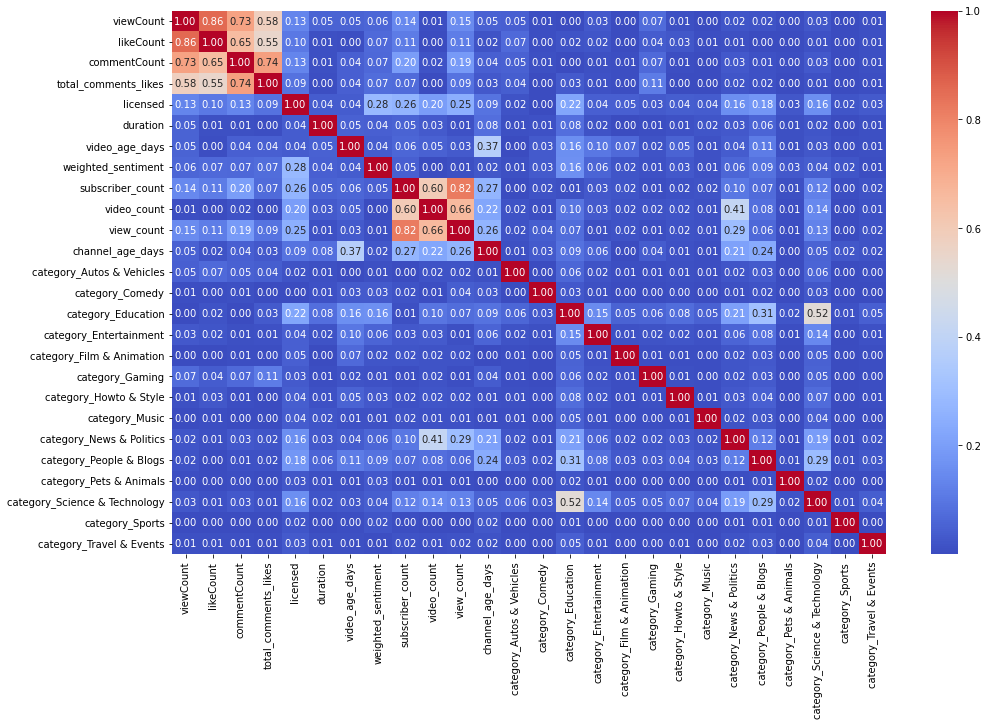

In [22]:
# Create correlation matrix
correlation_matrix = df_videos_standardized[numerical_columns].corr()

plt.figure(figsize=(16,10))
sns.heatmap(np.abs(correlation_matrix), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.savefig('../assets/correlation_matrix_videos.jpg', dpi=300)
plt.show();

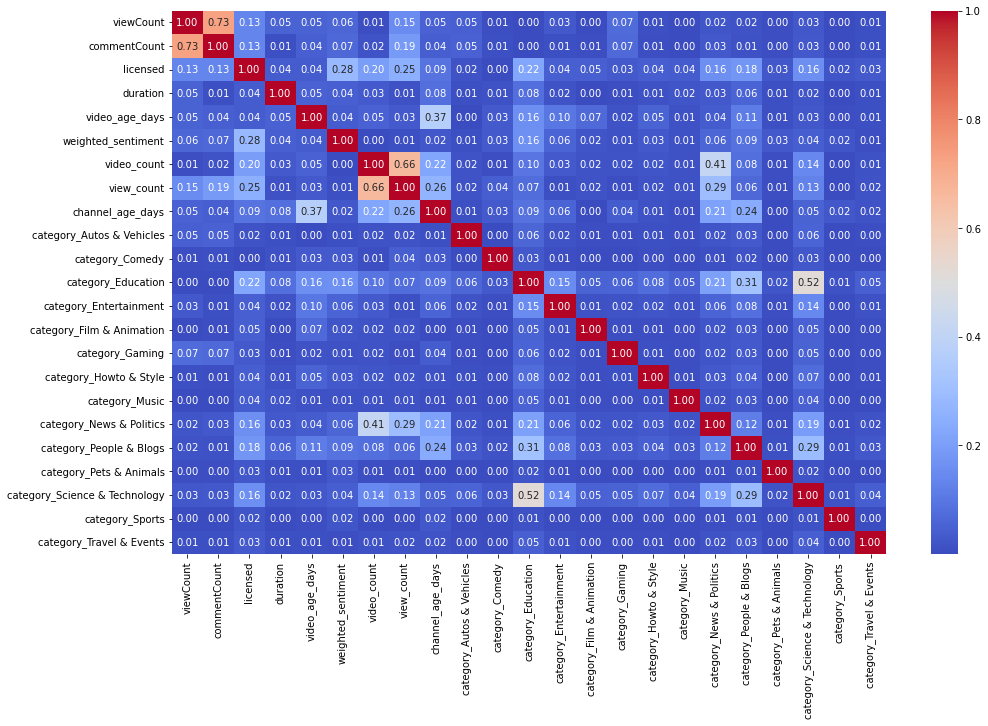

In [23]:
# Let's remove the highest correlated variables
high_correlation_variables = ['likeCount', 'total_comments_likes', 'subscriber_count']

# Drop the columns from standardize dataset
numerical_columns_clean = [column for column in numerical_columns if column not in high_correlation_variables]

# Re-plot the new correlation matrix
correlation_matrix = df_videos_standardized[numerical_columns_clean].corr()
plt.figure(figsize=(16,10))
sns.heatmap(np.abs(correlation_matrix), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.savefig('../assets/correlation_matrix_corrected.jpg', dpi=150)
plt.show();

In [24]:
df_videos_standardized.dropna(inplace=True)

# K-Means Clustering for Relevance Labeling

In [25]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Initialize the PCA model (for 2 components)
pca = PCA(n_components=2)

# Fit and transform the data
pca_components = pca.fit_transform(df_videos_standardized[numerical_columns_clean])

# Create a DataFrame with the PCA results
df_pca = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])

kmeans = KMeans(n_clusters=3)

kmeans.fit(df_pca.dropna())

df_pca['cluster'] = kmeans.labels_
df_videos['kmeans_cluster'] = kmeans.labels_

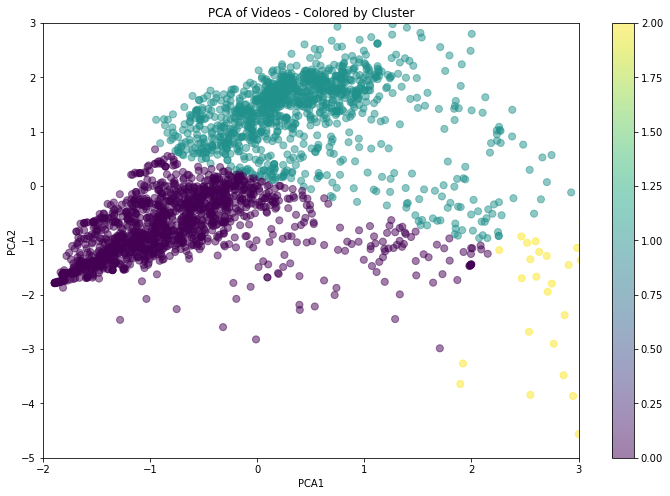

In [26]:
plt.figure(figsize=(12, 8))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['cluster'], cmap='viridis', s=50, alpha=0.5)
plt.colorbar()
plt.title('PCA of Videos - Colored by Cluster')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.xlim(-2, 3)
plt.ylim(-5, 3)
plt.savefig('../assets/kmeans_clusters.jpg', dpi=300)
plt.show()

In [27]:
# Cluster Analysis
# View the number of videos in each cluster
cluster_counts = df_pca['cluster'].value_counts()
print(cluster_counts)

cluster
0    1474
1    1099
2     137
Name: count, dtype: int64


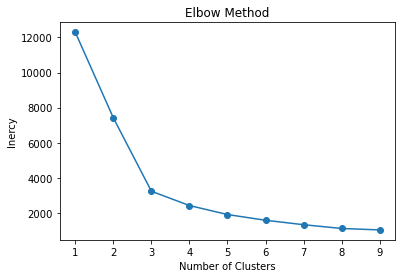

In [28]:
import matplotlib.pyplot as plt

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_pca)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inercy')
plt.title('Elbow Method')
plt.savefig('../assets/elbow_kmeans.jpg', dpi=150)
plt.show()

In [29]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
silhouette_avg = silhouette_score(df_pca.dropna(), kmeans.labels_)

print(f"The average silhouette score is: {silhouette_avg:.4f}")

The average silhouette score is: 0.4208


# DBSCAN Clustering

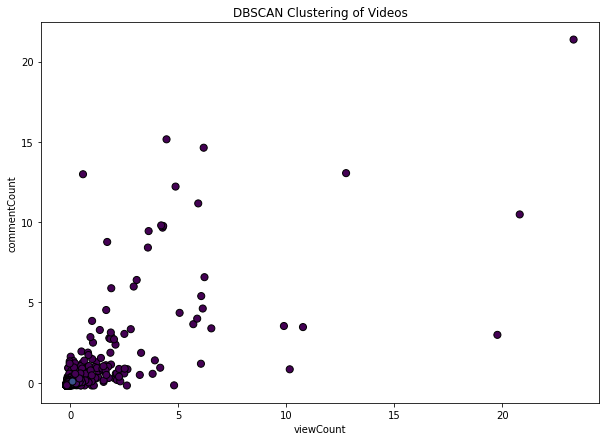

Estimated number of clusters: 35
Estimated number of noise points: 1225


In [30]:
from sklearn.cluster import DBSCAN

# eps: The maximum distance between two samples for them to be considered as in the same neighborhood
# min_samples: The number of samples in a neighborhood for a point to be considered as a core point

dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(df_videos_standardized[numerical_columns_clean])

# Add the cluster labels to the DataFrame
df_videos_standardized['cluster'] = clusters

# Plotting the clustering result using the first two features
plt.figure(figsize=(10, 7))
plt.scatter(df_videos_standardized[numerical_columns_clean[0]], df_videos_standardized[numerical_columns_clean[1]], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('DBSCAN Clustering of Videos')
plt.xlabel(numerical_columns_clean[0])
plt.ylabel(numerical_columns_clean[1])
plt.show()

# Analyzing the results
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

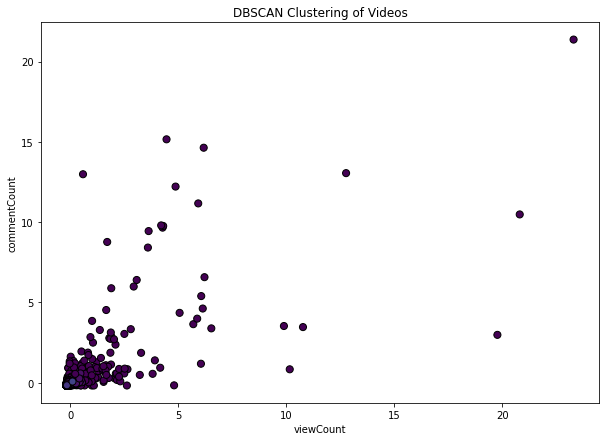

Estimated number of clusters: 25
Estimated number of noise points: 762


In [31]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import pandas as pd

# Assuming df_videos_standardized and numerical_columns_clean are already defined
# Apply DBSCAN

X = df_videos_standardized[numerical_columns_clean]
min_samples = 5

dbscan = DBSCAN(eps=0.7, min_samples=min_samples)
clusters = dbscan.fit_predict(X)

# Add the cluster labels to the DataFrame
df_videos_standardized['cluster'] = clusters

# Plotting the clustering result using the first two features
plt.figure(figsize=(10, 7))
plt.scatter(X['viewCount'], X['commentCount'], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('DBSCAN Clustering of Videos')
plt.xlabel(numerical_columns_clean[0])
plt.ylabel(numerical_columns_clean[1])
plt.show()

# Analyzing the results
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')


<AxesSubplot:xlabel='cluster'>

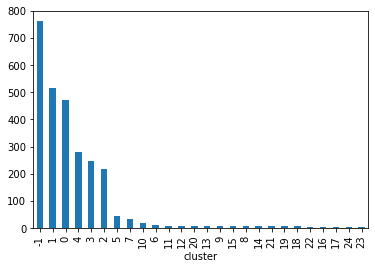

In [32]:
df_videos_standardized['cluster'].value_counts().plot(kind='bar')

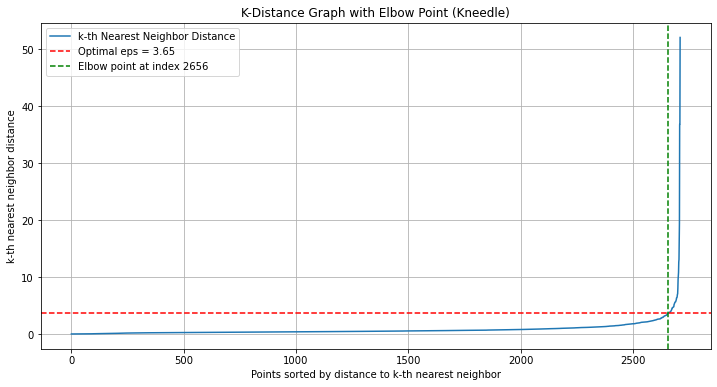

Optimal eps value: 3.6474363687143576


In [33]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# Setting 'k' equal to min_samples - 1 (assuming min_samples is 4 for this example)
k = min_samples - 1

# Initialize NearestNeighbors with n_neighbors as 'k'
# Use the 'ball_tree' algorithm for efficient distance computation
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)

# Find the distance to the k-th nearest neighbor for each point
# distances: Array of distances to k-th nearest neighbor
# indices: The indices of the k-th nearest neighbor in the dataset
distances, indices = nbrs.kneighbors(X)

# Sort the distances
sorted_distances = np.sort(distances[:, k-1], axis=0)

# Use the KneeLocator to find the elbow
kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, curve='convex', direction='increasing')
optimal_eps = sorted_distances[kneedle.elbow]

# Plotting the k-distance Graph
plt.figure(figsize=(12, 6))
plt.plot(sorted_distances, label='k-th Nearest Neighbor Distance')
plt.axhline(y=optimal_eps, color='r', linestyle='--', label=f'Optimal eps = {optimal_eps:.2f}')
plt.axvline(x=kneedle.elbow, color='g', linestyle='--', label=f'Elbow point at index {kneedle.elbow}')
plt.title('K-Distance Graph with Elbow Point (Kneedle)')
plt.xlabel('Points sorted by distance to k-th nearest neighbor')
plt.ylabel('k-th nearest neighbor distance')
plt.legend()
plt.grid(True)
plt.savefig('../assets/kdistance_dbscan.jpg', dpi=150)
plt.show()

print(f'Optimal eps value: {optimal_eps}')

In [34]:
df_videos_standardized.to_csv('../data/clean_data/df_videos_standardized.csv', index=False)

# DBScan with PCA Components

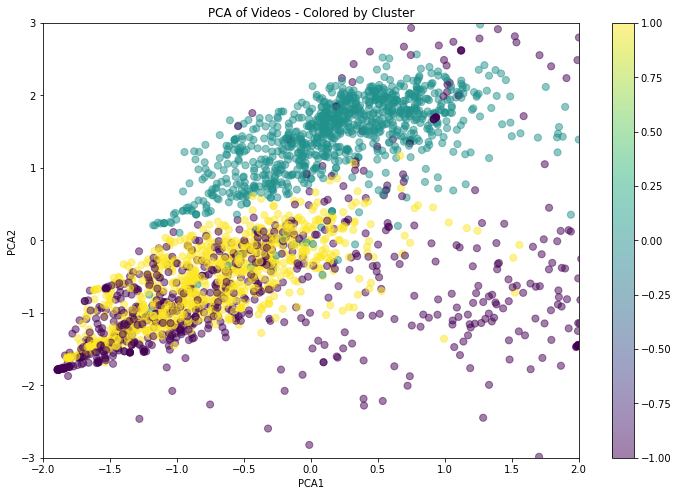

Estimated number of clusters: 3
Estimated number of noise points: 762
The average silhouette score is: 0.3891


In [35]:
from sklearn.decomposition import PCA

X = df_videos_standardized[numerical_columns_clean].copy()   

# Initialize the PCA model for 2 components
pca = PCA(n_components=2)

# Fit and transform the data using PCA
pca_components = pca.fit_transform(X)

# Create a DataFrame with the PCA results
df_pca = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])

# Apply DBScan using one of the previously suggested combinations
dbscan_model = DBSCAN(eps=2.65, min_samples=450)
dbscan_labels = dbscan_model.fit_predict(X)

# Add the DBScan cluster labels to the PCA DataFrame
df_pca['cluster'] = dbscan_labels
df_videos['dbscan_cluster'] = dbscan_labels

# Display the first few rows of the PCA DataFrame
df_pca.head()

plt.figure(figsize=(12, 8))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['cluster'], cmap='viridis', s=50, alpha=0.5)
plt.colorbar()
plt.title('PCA of Videos - Colored by Cluster')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.xlim(-2, 2)
plt.ylim(-3,3)
plt.savefig('../assets/dbscan_clusters.jpg', dpi=150)
plt.show()

# Analyzing the results
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f'Estimated number of clusters: {len(set(dbscan_labels))}')
print(f'Estimated number of noise points: {n_noise_}')

# Calculate the silhouette score
silhouette_avg = silhouette_score(df_pca.dropna(), dbscan_labels)

print(f"The average silhouette score is: {silhouette_avg:.4f}")

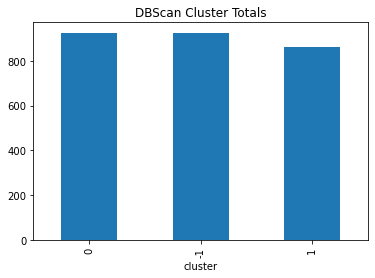

In [36]:
df_pca['cluster'].value_counts().plot(kind='bar')
plt.title('DBScan Cluster Totals')
plt.savefig('../assets/dbscan_clusters_total.jpg', dpi=150)


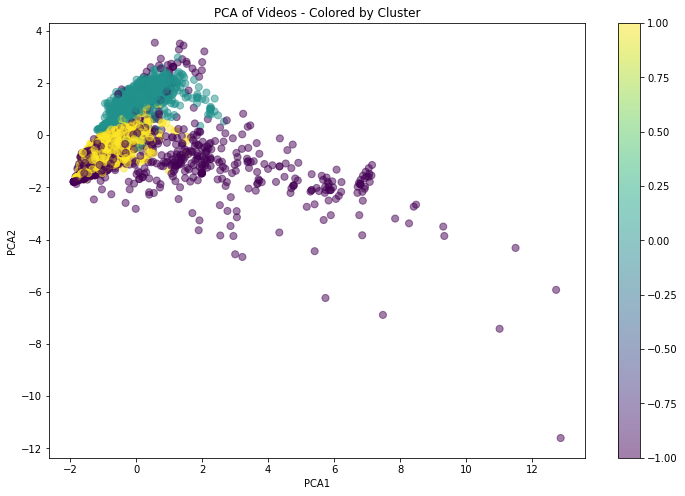

In [37]:
plt.figure(figsize=(12, 8))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['cluster'], cmap='viridis', s=50, alpha=0.5)
plt.colorbar()
plt.title('PCA of Videos - Colored by Cluster')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.savefig('../assets/dbscan_large.jpg', dpi=300)
plt.show()

# Final Score: TD-IDF * Weighted Sentiment * Kmeans Clusters

In [38]:
df_merged = df_merged.merge(df_videos[['video_id', 'dbscan_cluster']], on='video_id', how='left')
df_merged['dbscan_cluster'].head()

0    0
1   -1
2   -1
3    1
4    0
Name: dbscan_cluster, dtype: int64

In [39]:
# Boost videos from same cluster
cluster_boost = 1.2  
cluster_number = int(df_videos[df_videos['video_id'] == video_id]['dbscan_cluster'])

# Get cluster boosted final score
df_merged['final_score'] = df_merged[df_merged['dbscan_cluster'] == cluster_number]['final_score'] * cluster_boost

# Order the videos by final_score
df_merged.sort_values(by='final_score', ascending=False, inplace=True)

/tmp/ipykernel_1014/385057838.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cluster_number = int(df_videos[df_videos['video_id'] == video_id]['dbscan_cluster'])


In [40]:
selected_columns = ['video_id', 'title', 'final_score']
video = df_videos[df_videos['video_id'] == video_id][['video_id', 'title']]
print(video.to_markdown(index=False))
print('\n')
print(df_merged[selected_columns].head(5).to_markdown(index=False))

| video_id    | title                                                                 |
|:------------|:----------------------------------------------------------------------|
| gZpUcsB9TFc | Uninformed Vs Informed Search in Artificial Intelligence with Example |


| video_id    | title                                                                                                |   final_score |
|:------------|:-----------------------------------------------------------------------------------------------------|--------------:|
| f8luGFRtshY | Depth First Search (DFS) with example | Uninformed Search | Artificial Intelligence                  |      0.659988 |
| SABX6YggDTU | Bidirectional search algorithm  | uninformed | Artificial intelligence | Lec-17 | Bhanu Priya        |      0.386069 |
| rmKOOxU4Gf4 | depth first search  algorithm | DFS | Uninformed | Artificial intelligence | Lec-14 | Bhanu Priya    |      0.348318 |
| HXGaabF6T7U | L14: Artificial Intelligence Technique | Kn

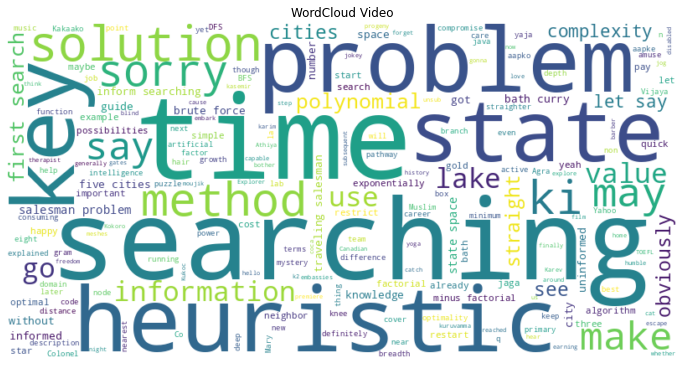

top 10 most frequent words
time: 1.0000
searching: 0.9167
problem: 0.9167
heuristic: 0.9167
state: 0.8333
key: 0.8333
solution: 0.8333
method: 0.7500
ki: 0.7500
sorry: 0.6667


In [41]:
from wordcloud import WordCloud

text =  model1[model1['video_id']== video_id]['transcription'].values[0]

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Print wordcloud graph
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Video')
plt.show()

# Extract top 10 most frequent words and frequency
word_frequencies = wordcloud.words_
top_10_words = sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True)[:10]

print(f'top 10 most frequent words')
for word, freq in top_10_words:
    print(f"{word}: {freq:.4f}")

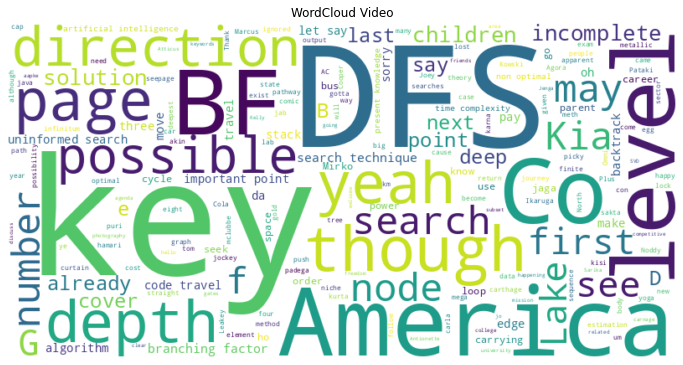

In [42]:
id = df_merged[selected_columns].head(1)['video_id'].values[0]
text =  model1[model1['video_id']== id]['transcription'].values[0]

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Print wordcloud graph
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Video')
plt.show()

# Save ML model

In [43]:
import joblib

model = cosine_similarity(tfidf_transcripts)
joblib.dump(model, 'tdidf_model')

['tdidf_model']

In [44]:
df_model = pd.DataFrame(model, index=model1['video_id'], columns=model1['video_id'])
df_model.head()

video_id,qtlUwwtvuEg,QaoDXYYtgK0,PqDwddEHswU,B-Y7rnOa43w,vyit-1zKsZ4,MWNqE4z2C34,SWeQO2SEOmQ,pRC4M5Na3jM,ax-3m4GSa1c,_8fDMmnDyYQ,...,I7Uqlv1WX18,qvbZmxUbGaE,Y2FOUg_jo7k,9gmeVAmsTW4,uuh7spVdf0c,Bm6CAjVtrIw,atiYXm7JZv0,plKAsDIiEJo,ZQazWxegNm8,CkG15bX4z90
video_id,,,,,,,,,,,,,,,,,,,,,
qtlUwwtvuEg,1.000000,0.065733,0.061912,0.151126,0.095740,0.133286,0.032403,0.026269,0.132834,0.195527,...,0.011048,0.049032,0.048195,0.025302,0.137597,0.121548,0.089471,0.020735,0.009270,0.091266
QaoDXYYtgK0,0.065733,1.000000,0.065913,0.060257,0.197272,0.111148,0.089107,0.037385,0.097818,0.105595,...,0.023071,0.044115,0.054087,0.039808,0.192708,0.070982,0.141533,0.010328,0.123580,0.048784
PqDwddEHswU,0.061912,0.065913,1.000000,0.045326,0.143175,0.139038,0.049364,0.053683,0.128130,0.174537,...,0.001226,0.065881,0.097605,0.025204,0.134635,0.142591,0.405382,0.029464,0.053422,0.033756
B-Y7rnOa43w,0.151126,0.060257,0.045326,1.000000,0.050299,0.042735,0.033021,0.014589,0.130971,0.222227,...,0.000000,0.052008,0.037969,0.015327,0.072554,0.017420,0.071598,0.007942,0.021755,0.026093
vyit-1zKsZ4,0.095740,0.197272,0.143175,0.050299,1.000000,0.177629,0.084440,0.072475,0.173870,0.116326,...,0.018901,0.065463,0.098764,0.060736,0.229210,0.113786,0.200721,0.061007,0.153180,0.066519


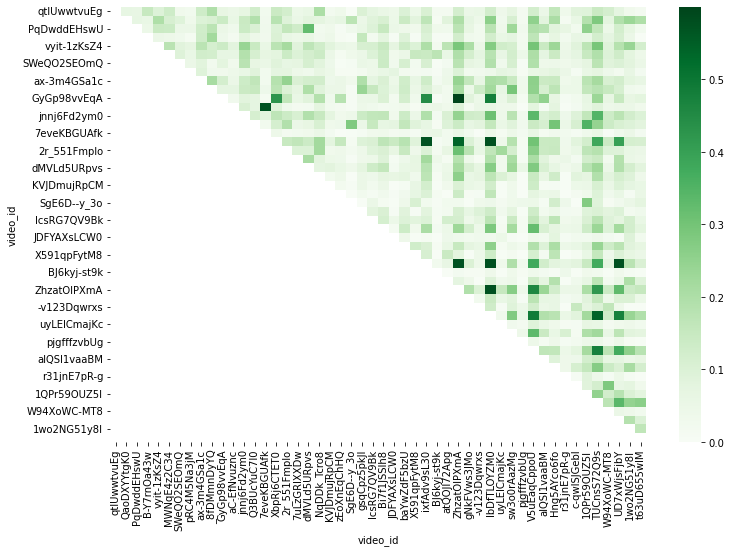

In [45]:
df_model = df_model.where(np.triu(np.ones(df_model.shape), k=1).astype(bool))
plt.figure(figsize=(12,8))
sns.heatmap(df_model.iloc[:50, :50], cmap='Greens')
plt.show();

In [46]:
model1.columns

Index(['video_id', 'transcription', 'language', 'clean_text', 'comment_list'], dtype='object')

<AxesSubplot:>

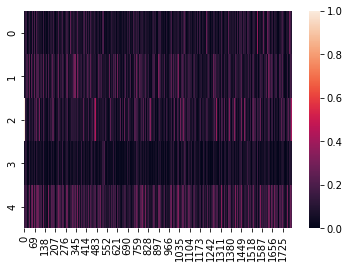

In [47]:
sns.heatmap(model[:5])

# FINAL PIPELINES FOR DEPLOYMENT

1. Calculate Cosine Similatiry Matrix

In [51]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Create tfidf matrix: create vectors from video_transcripts
def create_tfidf_matrix(df):
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])
    
    return tfidf_vectorizer, tfidf_matrix

# Create cosine_sim_matrix: matrix based on similarity of tfidf vectors
def calculate_cosine_similarity(tfidf_matrix, video_ids):
    cosine_sim_matrix = cosine_similarity(tfidf_matrix)
    cosine_sim_triangular = np.triu(cosine_sim_matrix, k=-1)
    cosine_sim_df = pd.DataFrame(cosine_sim_triangular, index=video_ids, columns=video_ids)
    return cosine_sim_df

In [52]:
# Load dataframe
df = model1.copy()

# Create tfidf model
tfidf_vectorizer, tfidf_matrix = create_tfidf_matrix(df)

# Create cosine_sim matrix from video_transcripts
cosine_sim_matrix = calculate_cosine_similarity(tfidf_matrix, df['video_id'])

cosine_sim_matrix.head()

video_id,qtlUwwtvuEg,QaoDXYYtgK0,PqDwddEHswU,B-Y7rnOa43w,vyit-1zKsZ4,MWNqE4z2C34,SWeQO2SEOmQ,pRC4M5Na3jM,ax-3m4GSa1c,_8fDMmnDyYQ,...,I7Uqlv1WX18,qvbZmxUbGaE,Y2FOUg_jo7k,9gmeVAmsTW4,uuh7spVdf0c,Bm6CAjVtrIw,atiYXm7JZv0,plKAsDIiEJo,ZQazWxegNm8,CkG15bX4z90
video_id,,,,,,,,,,,,,,,,,,,,,
qtlUwwtvuEg,1.000000,0.065733,0.061912,0.151126,0.095740,0.133286,0.032403,0.026269,0.132834,0.195527,...,0.011048,0.049032,0.048195,0.025302,0.137597,0.121548,0.089471,0.020735,0.009270,0.091266
QaoDXYYtgK0,0.065733,1.000000,0.065913,0.060257,0.197272,0.111148,0.089107,0.037385,0.097818,0.105595,...,0.023071,0.044115,0.054087,0.039808,0.192708,0.070982,0.141533,0.010328,0.123580,0.048784
PqDwddEHswU,0.000000,0.065913,1.000000,0.045326,0.143175,0.139038,0.049364,0.053683,0.128130,0.174537,...,0.001226,0.065881,0.097605,0.025204,0.134635,0.142591,0.405382,0.029464,0.053422,0.033756
B-Y7rnOa43w,0.000000,0.000000,0.045326,1.000000,0.050299,0.042735,0.033021,0.014589,0.130971,0.222227,...,0.000000,0.052008,0.037969,0.015327,0.072554,0.017420,0.071598,0.007942,0.021755,0.026093
vyit-1zKsZ4,0.000000,0.000000,0.000000,0.050299,1.000000,0.177629,0.084440,0.072475,0.173870,0.116326,...,0.018901,0.065463,0.098764,0.060736,0.229210,0.113786,0.200721,0.061007,0.153180,0.066519


2. Adjust matrix to sentiment_scores

In [53]:
# Get final sentiment scores
df_sentiment_scores = df_merged[['video_id', 'weighted_sentiment']].copy()

# Set the video_id as index
df_sentiment_scores = df_sentiment_scores.set_index('video_id')['weighted_sentiment']

# Re-index as per cosine_sim_matrix to have the same order, filling the videos_id without sentiment score as '0' netural
sentiment_scores = df_sentiment_scores.reindex(cosine_sim_matrix.index, fill_value=0)

# Multiply sentiment_score and its transpose by cosine_sim_matrix
sentiment_product_matrix = (1 + sentiment_scores) * cosine_sim_matrix

# Create symmetrical matrix for better visualization
symm_matrix = sentiment_product_matrix + sentiment_product_matrix.T
np.fill_diagonal(symm_matrix.values, 0)

symm_matrix

video_id,qtlUwwtvuEg,QaoDXYYtgK0,PqDwddEHswU,B-Y7rnOa43w,vyit-1zKsZ4,MWNqE4z2C34,SWeQO2SEOmQ,pRC4M5Na3jM,ax-3m4GSa1c,_8fDMmnDyYQ,...,I7Uqlv1WX18,qvbZmxUbGaE,Y2FOUg_jo7k,9gmeVAmsTW4,uuh7spVdf0c,Bm6CAjVtrIw,atiYXm7JZv0,plKAsDIiEJo,ZQazWxegNm8,CkG15bX4z90
video_id,,,,,,,,,,,,,,,,,,,,,
qtlUwwtvuEg,0.000000,0.176311,0.100043,0.302251,0.125557,0.229211,0.032403,0.046945,0.265668,0.293291,...,0.015539,0.076192,0.073340,0.025302,0.137597,0.181710,0.161797,0.020735,0.011716,0.091266
QaoDXYYtgK0,0.176311,0.000000,0.176560,0.120515,0.258712,0.191142,0.089107,0.066809,0.195635,0.158392,...,0.032449,0.068552,0.082306,0.039808,0.192708,0.106116,0.255944,0.010328,0.156188,0.048784
PqDwddEHswU,0.100043,0.176560,0.000000,0.163895,0.187766,0.239104,0.049364,0.095935,0.256261,0.261806,...,0.001724,0.102375,0.148528,0.025204,0.134635,0.213168,0.733083,0.029464,0.067517,0.033756
B-Y7rnOa43w,0.302251,0.120515,0.163895,0.000000,0.166562,0.073491,0.033021,0.026071,0.261941,0.333341,...,0.000000,0.080816,0.057779,0.015327,0.072554,0.026042,0.129476,0.007942,0.027495,0.026093
vyit-1zKsZ4,0.125557,0.258712,0.187766,0.166562,0.000000,0.538421,0.084440,0.129519,0.347741,0.174489,...,0.026584,0.101725,0.150292,0.060736,0.229210,0.170106,0.362979,0.061007,0.193597,0.066519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bm6CAjVtrIw,0.181710,0.106116,0.213168,0.026042,0.170106,0.219890,0.117770,0.073117,0.154440,0.078936,...,0.000000,0.054468,0.118787,0.086565,0.427814,0.000000,0.701407,0.020233,0.045970,0.050405
atiYXm7JZv0,0.161797,0.255944,0.733083,0.129476,0.362979,0.258778,0.222322,0.107664,0.365875,0.360088,...,0.005716,0.167719,0.421347,0.073367,0.473988,0.701407,0.000000,0.128680,0.231529,0.045666
plKAsDIiEJo,0.020735,0.010328,0.029464,0.007942,0.061007,0.073709,0.039726,0.011971,0.047179,0.063281,...,0.000000,0.018287,0.041058,0.000000,0.058428,0.020233,0.128680,0.000000,0.123851,0.025496


3. Adjust matrix to clusters boost

In [54]:
# Load clusters data
df_merged[['video_id','dbscan_cluster']].head()
cluster_scores = df_merged[['video_id','dbscan_cluster']].copy()

# Reindex as per cosine_sim_matrix
cluster_scores = cluster_scores.set_index('video_id')['dbscan_cluster']

# Fill empty values to '-1' cluster (videos not belonging to cluster 0 or 1)
df_cluster_scores = cluster_scores.reindex(cosine_sim_matrix.index, fill_value=-1)

# Create a boolean mask where the cluster is the same for both videos
same_cluster_mask = df_cluster_scores.values[:, None] == df_cluster_scores.values

# Set '0' for False and '1.2' (cluster_boost) for True values
boost_factor_matrix = np.where(same_cluster_mask, 1.2, 1)

# Multiply the consine_sim_matrix by the boost_factor_matrix
final_score_matrix = symm_matrix * boost_factor_matrix

final_score_matrix

video_id,qtlUwwtvuEg,QaoDXYYtgK0,PqDwddEHswU,B-Y7rnOa43w,vyit-1zKsZ4,MWNqE4z2C34,SWeQO2SEOmQ,pRC4M5Na3jM,ax-3m4GSa1c,_8fDMmnDyYQ,...,I7Uqlv1WX18,qvbZmxUbGaE,Y2FOUg_jo7k,9gmeVAmsTW4,uuh7spVdf0c,Bm6CAjVtrIw,atiYXm7JZv0,plKAsDIiEJo,ZQazWxegNm8,CkG15bX4z90
video_id,,,,,,,,,,,,,,,,,,,,,
qtlUwwtvuEg,0.000000,0.176311,0.100043,0.302251,0.150669,0.275054,0.032403,0.046945,0.265668,0.293291,...,0.015539,0.091431,0.073340,0.025302,0.165116,0.218052,0.161797,0.020735,0.011716,0.109520
QaoDXYYtgK0,0.176311,0.000000,0.176560,0.120515,0.258712,0.191142,0.106928,0.080171,0.234762,0.190070,...,0.032449,0.068552,0.082306,0.039808,0.192708,0.106116,0.255944,0.012394,0.187425,0.048784
PqDwddEHswU,0.100043,0.176560,0.000000,0.196674,0.187766,0.239104,0.049364,0.095935,0.256261,0.261806,...,0.002068,0.102375,0.178233,0.030244,0.134635,0.213168,0.879699,0.029464,0.067517,0.033756
B-Y7rnOa43w,0.302251,0.120515,0.196674,0.000000,0.166562,0.073491,0.033021,0.026071,0.261941,0.333341,...,0.000000,0.080816,0.069335,0.018392,0.072554,0.026042,0.155371,0.007942,0.027495,0.026093
vyit-1zKsZ4,0.150669,0.258712,0.187766,0.166562,0.000000,0.646105,0.084440,0.129519,0.347741,0.174489,...,0.026584,0.122069,0.150292,0.060736,0.275052,0.204127,0.362979,0.061007,0.193597,0.079823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bm6CAjVtrIw,0.218052,0.106116,0.213168,0.026042,0.204127,0.263868,0.117770,0.073117,0.154440,0.078936,...,0.000000,0.065361,0.118787,0.086565,0.513377,0.000000,0.701407,0.020233,0.045970,0.060485
atiYXm7JZv0,0.161797,0.255944,0.879699,0.155371,0.362979,0.258778,0.222322,0.107664,0.365875,0.360088,...,0.006859,0.167719,0.505616,0.088040,0.473988,0.701407,0.000000,0.128680,0.231529,0.045666
plKAsDIiEJo,0.020735,0.012394,0.029464,0.007942,0.061007,0.073709,0.047671,0.014365,0.056615,0.075937,...,0.000000,0.018287,0.041058,0.000000,0.058428,0.020233,0.128680,0.000000,0.148621,0.025496


4. Save the matrix as 'joblib' for deployment

In [478]:
# Save the final_score_matrix dataframe for deployment

joblib.dump(final_score_matrix, '../ml_deploy/final_score_matrix.joblib')

['../ml_deploy/final_score_matrix.joblib']

5. Test app

In [486]:
import random

# Load dataframe
final_matrix = joblib.load('../docker_app/final_score_matrix.joblib')

# Set a random video as the first one
initial_video = random.choice(final_matrix.index)

# Recommend the top 10 videos
top_10_videos = final_matrix[initial_video].sort_values(ascending=False)[:10]

print(f'Initial video: {initial_video}\n')
print(f'Top 10 recommended videos: {top_10_videos}')

Initial video: 28ugd8lS5k8

Top 10 recommended videos: video_id
K6LN3ioaOHQ    0.685722
8O3lBTU2Ngg    0.480498
VNz3KGoAhG4    0.478976
-3Yexx70g24    0.438615
pTHBZ6AyzOg    0.438212
-cT1m6NZYWc    0.431067
0l9Pu4dk89c    0.399885
7V_AebZFlpo    0.386479
lA8jzurgRrU    0.384465
ysQun8VbUmM    0.378987
Name: 28ugd8lS5k8, dtype: float64


# . . .

Future steps: model evaluation

Precision@K

$$
\text{Precision@K} = \frac{\text{Número de elementos relevantes en el top K}}{K}
$$


Recall@K
$$
\text{Recall@K} = \frac{\text{Número de elementos relevantes en el top K}}{\text{Número total de elementos relevantes}}
$$


F1-Score@K
$$
\text{F1-Score@K} = 2 \times \frac{\text{Precision@K} \times \text{Recall@K}}{\text{Precision@K} + \text{Recall@K}}
$$
